In [400]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import make_swiss_roll, make_s_curve
from scipy.sparse import csr_matrix, spdiags
from sklearn.utils.graph import graph_laplacian as sklaplacian
from scipy.sparse.linalg import eigsh

import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
plt.style.use('ggplot')

%matplotlib inline

This notebook will walk through the steps of Laplacian Eigenmaps (LE) algorithm. It will be a step-by-step walkthrough of the algorithm and towards the notebook, I will work on some common known speed-up attempts.

In [401]:
seed = 123
rng = np.random.seed(123)
n_samples = 1500
noise = 0.1
random_state = seed

data, color = make_swiss_roll(n_samples=n_samples, noise=noise, random_state=random_state)
data, color = make_s_curve(n_samples=n_samples, noise=noise, random_state=random_state)

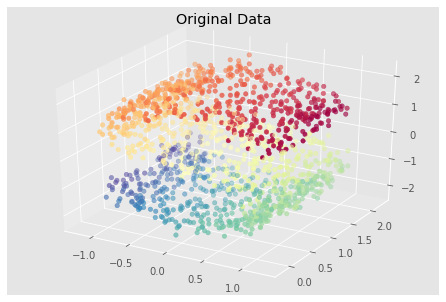

In [402]:
fig = plt.figure()

ax = p3.Axes3D(fig)

ax.scatter(data[:,0], data[:, 1], data[:,2], c=color, cmap=plt.cm.Spectral)
ax.set_title("Original Data")
plt.show()

## Adjacency Matrix Construction

### Nearest Neighbours Search

In [403]:
# some baseline parameters
n_neighbors = 10
algorithm = 'brute'
metric = 'euclidean'
p=2
n_jobs = -1

# initialize nn model
nn_model = NearestNeighbors(
    n_neighbors=n_neighbors,
    metric=metric,
    algorithm=algorithm,
    p=p,
    n_jobs=n_jobs
)

# fit nn model to data
nn_model.fit(data);

# grab distances and indices
dists, indices = nn_model.kneighbors(
    data, 
    n_neighbors=n_neighbors, 
    return_distance=True
)

### Weighted Distances

In [404]:
# Heat kernel
def heat_kernel(distances, length_scale=None):
    if length_scale is None:
        length_scale = 1.0
#         length_scale = np.sqrt(distances.shape[1] / 2.0)
#         length_scale = 1.0 / distances.shape[1]
#     return np.exp(- length_scale * distances**2)
    return np.exp(- distances**2 / length_scale)

In [250]:
# transform distances with heat kernel
dists = heat_kernel(dists)

### Construct Graph

In [405]:
# Construct sparse KNN Graph
n_samples = data.shape[0]

indptr = np.arange(0, n_samples * n_neighbors + 1, n_neighbors)

adjacency_matrix = csr_matrix((dists.ravel(), indices.ravel(), indptr), shape=(n_samples, n_samples))

# ensure that its symmetrix
adjacency_matrix = 0.5 * (adjacency_matrix + adjacency_matrix.T)

#### Peak at Adjacency Matrix

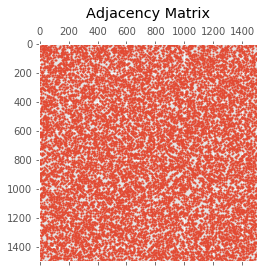

In [406]:

fig, ax = plt.subplots()

ax.spy(adjacency_matrix, markersize=1.0)
ax.set_title('Adjacency Matrix', pad=15.0)

plt.show()

## Laplacian Matrix

Some notes about some different Laplacian matrices:

**Unnormalized Graph Laplacian**

$$L=D-W$$

**Symmetric Normalized Graph Laplacian**

$$L_{Sym}=D^{-\frac{1}{2}}LD^{-\frac{1}{2}}$$

**Random Walk Normalized Laplacian**

$$L_{rw}=D^{-1}L$$

**Random Walk Transition Matrix**

$$L_{rwt}=D^{-1}W$$

### Laplacian and Degree Matrix

In [407]:
def graph_laplacian(adjacency_matrix, graph_type='normalized', return_diag=True):
    
    n_samples = adjacency_matrix.shape[0]
    
    # Get degree vector
    degree = np.array(adjacency_matrix.sum(axis=1)).squeeze()
    
    # Create Sparse matrix for degree
    degree_mat = spdiags(
        degree, diags=0, m=n_samples, n=n_samples
    )
    
    if graph_type in ['unnormalized']:
        laplacian = degree_mat - adjacency_matrix
    elif graph_type in ['normalized']:
        laplacian = degree_mat - adjacency_matrix
        norm = 1 / np.sqrt(degree_mat)
        laplacian = norm @ adjacency_matrix @ norm
    

    
    # Set all values 
    
    # set diagonal elements of array to negative
    
    
    return laplacian, degree_mat

In [485]:
%%time

normed = True
# laplacian, degree = graph_laplacian(adjacency_matrix, 'unnormalized')
laplacian, degree = sklaplacian(
    adjacency_matrix, normed=normed, return_diag=True
)

CPU times: user 1.57 ms, sys: 793 µs, total: 2.36 ms
Wall time: 2.26 ms


In [486]:
print(laplacian.min(), laplacian.max())

-0.1998550568581986 1.0


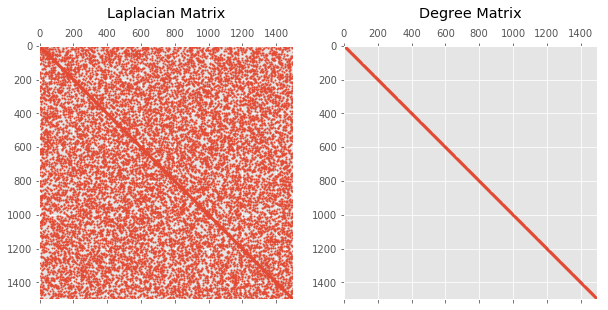

In [487]:
fig, ax = plt.subplots(figsize=(10, 6), nrows=1, ncols=2)

ax[0].spy(laplacian, markersize=1.0)
ax[0].set_title('Laplacian Matrix', pad=15.0)

ax[1].spy(np.diag(degree), markersize=1.0)
ax[1].set_title('Degree Matrix', pad=15.0)

plt.show()

## EigenValue Decomposition

|        Algorithm       |      Laplacian Equation      | Generalized Eigenvalue | Standard Eigenvalue |
|:----------------------:|:----------------------------:|:----------------------:|:-------------------:|
| Unnormalized Laplacian | $$L=D-W$$                    | $$LF=\lambda DF$$      |                     |
| Normalized Laplacian   | $$L{sym}=D^{-1/2}LD^{-1/2}$$ |                        |                     |
| Random Walk Normalized | $$L_{rw}=D^{-1}L$$           |                        |                     |
| Random Walk Transition | $$L_{rwt}=D^{-1}W$$          |                        |                     |
| ReNormalized           |                              |                        |                     |
| Geometric              |                              |                        |                     |

### Generalized Eigenvalue Solver

In [488]:
from sklearn.manifold import spectral_embedding

In [489]:
n_components = 2
eigen_solver = 'arpack'
random_state = 123
eigen_tol = 0.0
norm_laplacian = normed
drop_first = True

embedding = spectral_embedding(
    adjacency_matrix, n_components=n_components,
    eigen_solver=eigen_solver, random_state=random_state,
    eigen_tol=eigen_tol, norm_laplacian=norm_laplacian,
    drop_first=drop_first
)

In [490]:
print(embedding.shape)

(1500, 2)


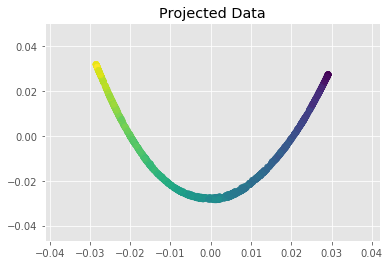

In [491]:
fig, ax = plt.subplots()

ax.scatter(embedding[:, 0], embedding[:, 1], c=color)
ax.set_title('Projected Data')
plt.show()

In [492]:
from sklearn.utils.extmath import _deterministic_vector_sign_flip

In [493]:
%%time

# Transform equation
laplacian_sol = -1 * laplacian

n_components = 2
solver = 'LM'      # Smallest to Largest
sigma = 1.0
eigen_tol = 0.0
v0 = np.random.uniform(-1, 1, laplacian.shape[0])

effective_components = n_components + 1

eigenvalues, eigenvectors = eigsh(
    laplacian_sol,
    k=effective_components,
    which=solver,
    sigma=sigma,
    tol=eigen_tol,
    v0=v0
)
# Transform eigenvectors
embedding = eigenvectors.T[effective_components::-1]

if normed:
    
    embedding = embedding / degree
    
# Check vector sign
embedding = _deterministic_vector_sign_flip(embedding)

embedding = embedding[1:effective_components].T

CPU times: user 185 ms, sys: 4.83 ms, total: 190 ms
Wall time: 110 ms


In [494]:
print(eigenvalues.shape, embedding.shape)

(3,) (1500, 2)


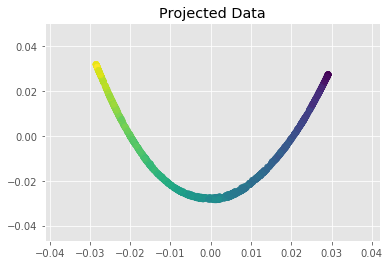

In [495]:
fig, ax = plt.subplots()

ax.scatter(embedding[:, 0], embedding[:, 1], c=color)
ax.set_title('Projected Data')
plt.show()